# 注意力机制

## 束搜索(beam search)

贪心搜索
- 在Seq2Seq中我们使用了贪心搜索来预测序列
  - 将当前时刻预测概率最大的词进行输出
- 但贪心很可能不是最优的

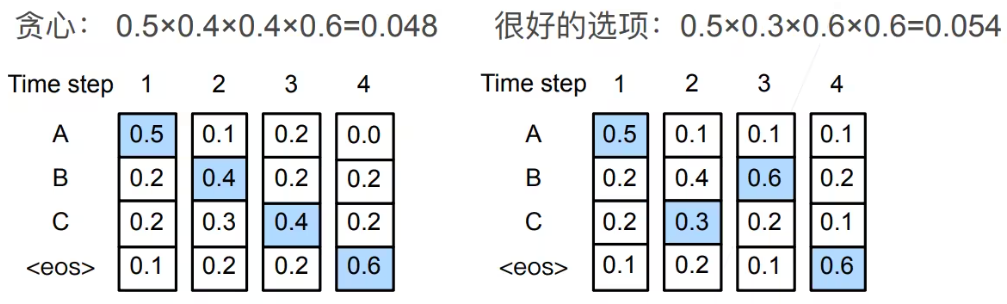

穷举搜索
- 最优算法：对所有可能的序列，计算它的概率，然后选取最好的那个
- 如果输出字典大小为n，序列长度为T，那么我们需要考察n^T个序列
  - n= 10000, T= 10
  - 计算上不可行

束搜索
- 保存最好的k个候选
- 在每个时刻，对每个候选新加一项(n种可能)，在kn选项中选择最好的k个

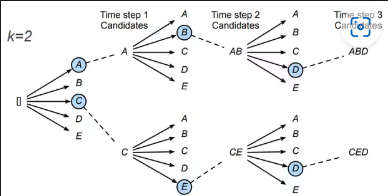

束搜索
- 时间复杂度O(knT)
  - k=5, n= 10000, T= 10: knT = 5*10^5
- 每个候选的最终分数是：

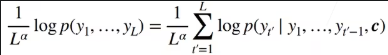

 - a通常为0.75

心理学
- 动物需要在复杂环境下有效关注值得注意的点
- 心理学框架：人类根据随意线索和不随意线索选择注意点

注意力机制
- 卷积、全连接、池化层都只考虑不随意线索
- 注意力机制则显示地考虑随意线索
  - 随意线索被称之为查询(Query)
  - 每一个输入是一个值(value)和不随意线索(key)的对
  - 通过注意力池化层来有偏向性地选择某些输入

非参注意力池化层
- 给定数据
- 平均池化是最简单的方案
- 更好的方案是60年代提出来的Nadaraya—Waston核回归

In [1]:
#注意力的可视化
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles= None, 
                  figsize= (2.5, 2.5), cmap= 'Reds'):
    """绘制矩阵热力图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize= figsize, 
                                 sharex= True, sharey= True, squeeze= False)
    for i, (row_axes, col_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, col_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap= cmap)
            if i == num_rows -1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax= axes, shrink= 0.6)

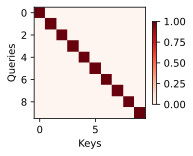

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel= 'Keys', ylabel= 'Queries')

In [4]:
# 注意力汇聚：Nadaraya——Waston和回归
#生成数据集
n_train = 50
#对训练样本进行排序
x_train, _ = torch.sort(torch.rand(n_train)* 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

#训练样本的输出
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
#测试样本
x_test = torch.arange(0, 5, 0.1)
#测试样本的真实输出
y_truth = f(x_test)
#测试样本数量

print(len(x_test))

50


In [5]:
def plot_kernel_reg(y_hat):
    """绘制所有的训练样本"""
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend= ['Truth', 'Pred'],
             xlim=[0, 5], ylim= [-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha= 0.5)

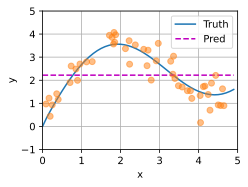

In [6]:
#平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), len(x_test))
plot_kernel_reg(y_hat)

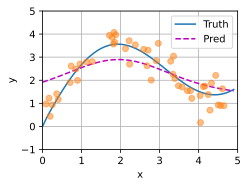

In [7]:
#X_repeat的形状：(n_test, n_train)
#每一行都包含相同的测试输入
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
#x_train包含键，attention_weights的形状:(n_test, n_train)
#每一行都包含着要在给定的每个查询的值(y_train)之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)** 2 / 2, dim= 1)
#y_hat的每个元素都是值的加权平均值，其中权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

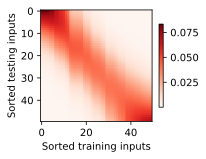

In [8]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel= 'Sorted training inputs',
                  ylabel= 'Sorted testing inputs')

In [9]:
#带参数的注意力机制
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape
#使用小批量矩阵乘法来计算小批量数据中的加权平均值
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [15]:
#定义Nadaraya-Watson核回归的带参数版本
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad= True))
    
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状均为(n_queries, n_key_value_pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys)* self.w)**2 / 2, dim= 1)
        #values的形状为(n_queries, n_key_value_pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [16]:
#将训练数据集变为键和值用于训练注意力模型
#X_title的形状：(n_train, n_train),每一行包含相同的训练输入
X_tile = x_train.repeat((n_train, 1))
#Y_title的形状：(n_train, n_train),每一行包含相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
#keys的形状：(n_train, n_train - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
#values的形状：(n_train, n_train - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

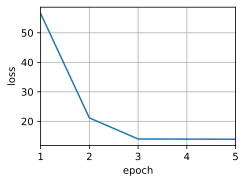

In [18]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction= 'none')
trainer = torch.optim.SGD(net.parameters(), lr= 0.5)
animator = d2l.Animator(xlabel= 'epoch', ylabel= 'loss', xlim= [1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    #计算总损失并反向传播
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

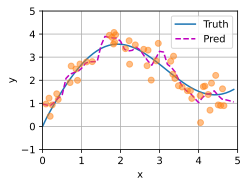

In [23]:
#尝试拟合带噪声的训练数据
#预测结果不如非参数模型平滑
#keys的形状：(n_test, n_train),每一行包含相同的训练输入
keys = x_train.repeat((len(x_test), 1))
#values的形状：(len(x_test), n_train)
values = y_train.repeat(len(x_test), 1)
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)